# 💻 ✍ Lab4 - Categorical, Multinomial, Dirichlet distributions with applications in mixture models and LDA

# ❗❗❗ Very important administrative detail

The lab changes its content once every **TWO WEEKS**.

*   week 1 & week 2 - lab1
*   week 3 & week 4 - lab2
*   week 5 & week 6 - lab3
*   **week 7 & week 8 - lab4**
* ...

# Conjugate Priors

Sometimes we don't need bayesian inference to find out the posterior due to a nice property of some distributions. For some pairs (prior, likelihood), the posterior is in the same family of distributions as the prior. When this happens, we say that the prior is a **conjugate prior** for that likelihood.

A table with some of the conjugate priors and their likelihoods can be found here: https://en.wikipedia.org/wiki/Conjugate_prior


# Categorical and Multinomial distributions

https://en.wikipedia.org/wiki/Categorical_distribution

https://en.wikipedia.org/wiki/Multinomial_distribution

They represent generalizations for Bernoulli and Binomial distributions. We consider $K$ possible categories. Categorical draws a category from $\{1...K\}$ (or $\{0...(K-1)\}$) with the probabilities passed as parameters for each category, while Multinomial draws a distribution over $N$ objects, each with probabilities passed as parameters for each category.

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import seaborn as sns

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [ ]:
x = pm.Categorical.dist(p=[0.5, 0.2 , 0.3])
for _ in range(10):
    print(pm.draw(x, draws=1))

2
1
2
0
0
2
0
2
0
0


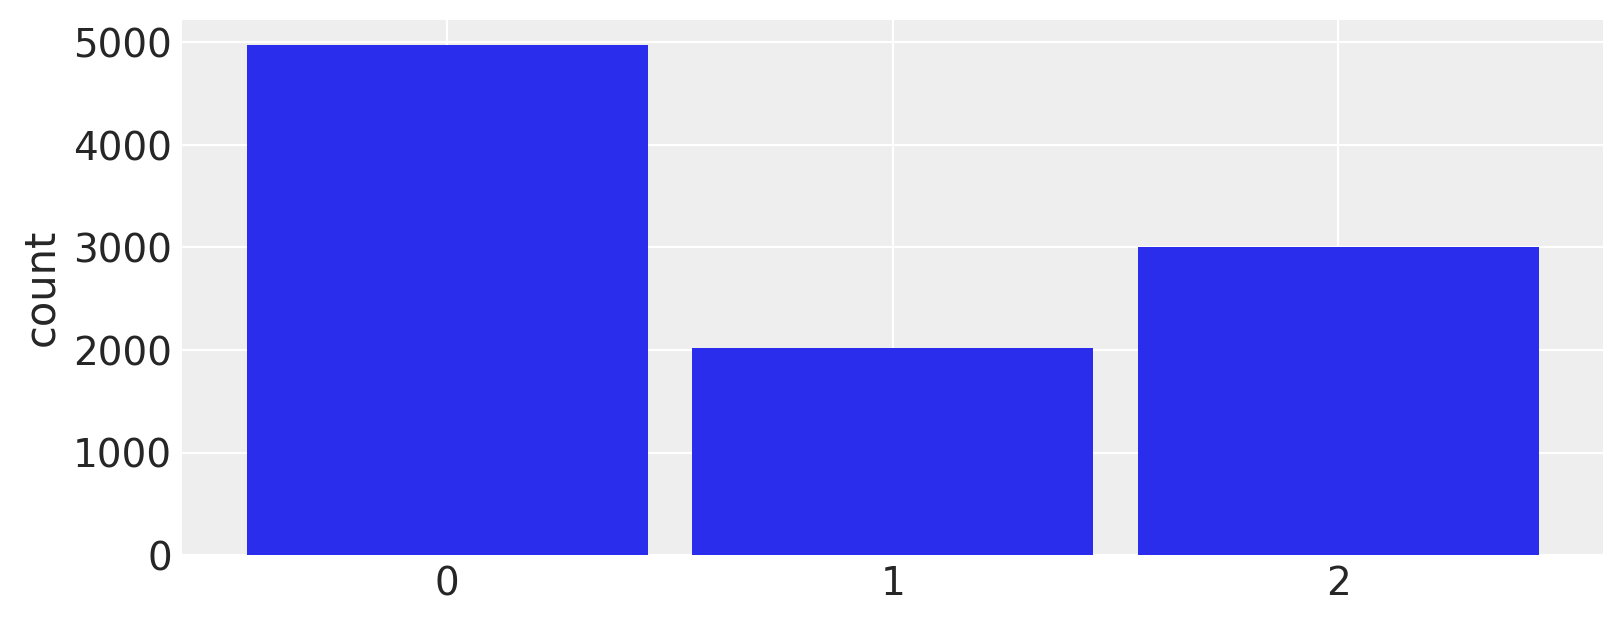

In [ ]:
v = pm.draw(x, draws=10_000)
az.plot_dist(v, figsize=(8, 3), hist_kwargs={'density': False}, color="C0")
plt.ylabel('count')
plt.show()
plt.close()

In [ ]:
x = pm.Multinomial.dist(n=10, p=[0.1, 0.2, 0.7])
for _ in range(20):
    print(pm.draw(x, draws=1))

[1 0 9]
[1 2 7]
[1 2 7]
[0 2 8]
[0 2 8]
[0 3 7]
[0 3 7]
[2 2 6]
[2 1 7]
[1 3 6]
[0 1 9]
[0 4 6]
[0 3 7]
[3 4 3]
[0 4 6]
[1 2 7]
[0 1 9]
[2 3 5]
[2 1 7]
[0 5 5]


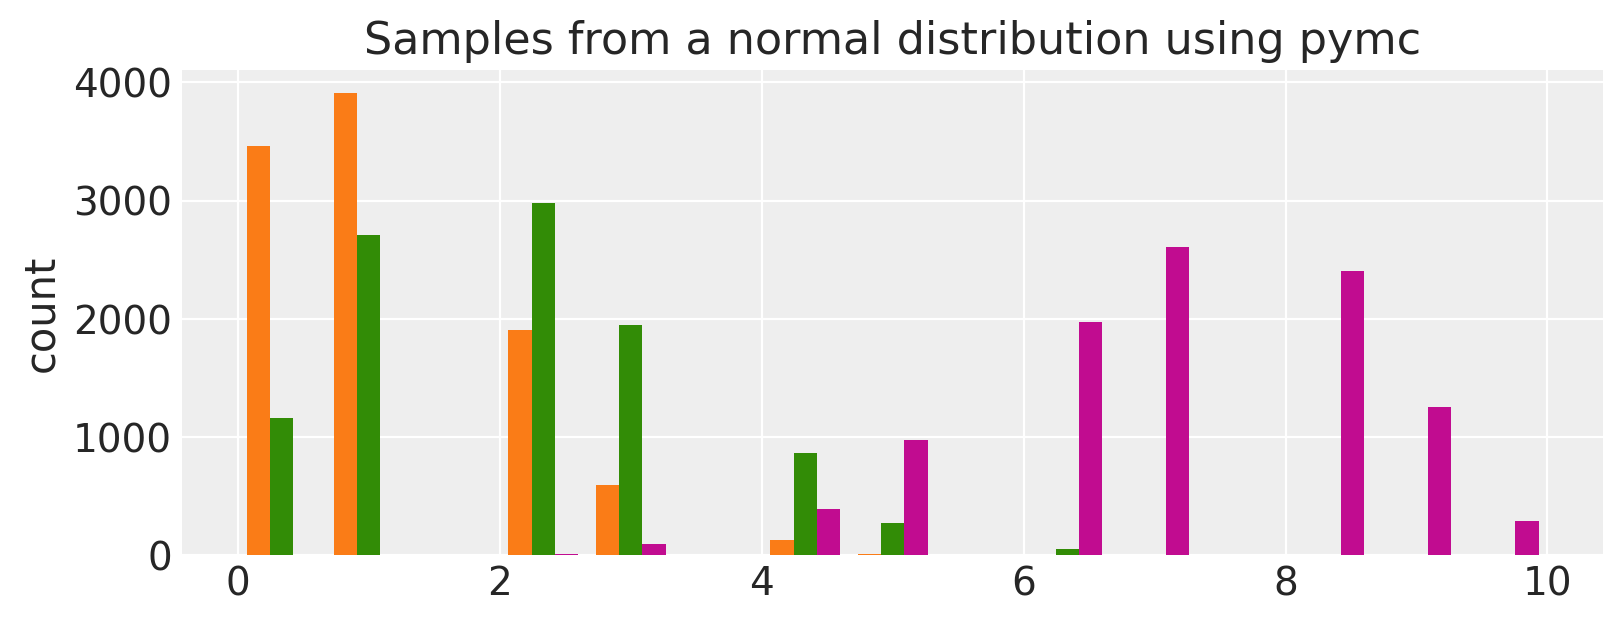

In [ ]:
v = pm.draw(x, draws=10_000)
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(v, color=['C1', 'C2', 'C3'], bins=15)
ax.set(title='Samples from a normal distribution using pymc', ylabel='count');
plt.show()

# Dirichlet distribution

Each draw from the Dirichlet distribution of dimensions $K$ generates **a vector of probabilities** of size $K$.

For $K=2$, the Dirichlet distribution becomes mathematically identical to the Beta distribution. Remember, the draw from a Beta is a value in $(0, 1)$ - a probability $p$. The pair $\vec{p}=(p, 1-p)$ creates the complete Dirichlet form from the Beta.

 - As Beta has 2 parameters ($\alpha, \beta$), the Dirichlet distribution of size $K$ has $K$ parameters, $\vec{\alpha} =(\alpha_1, \alpha_2, ... \alpha_K)$.

 - As Beta is a conjugate prior to Bernoulli, Dirichlet is a conjugate prior to Categorical.

 - As Beta is a conjugate prior to Binomial, Dirichlet is a conjugate prior to Multinomial.

 To learn more about Dirichlet visually you can use the $K-1$ simplex visualization:

 https://upload.wikimedia.org/wikipedia/commons/7/74/Dirichlet.pdf

/tmp/ipython-input-3429593414.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


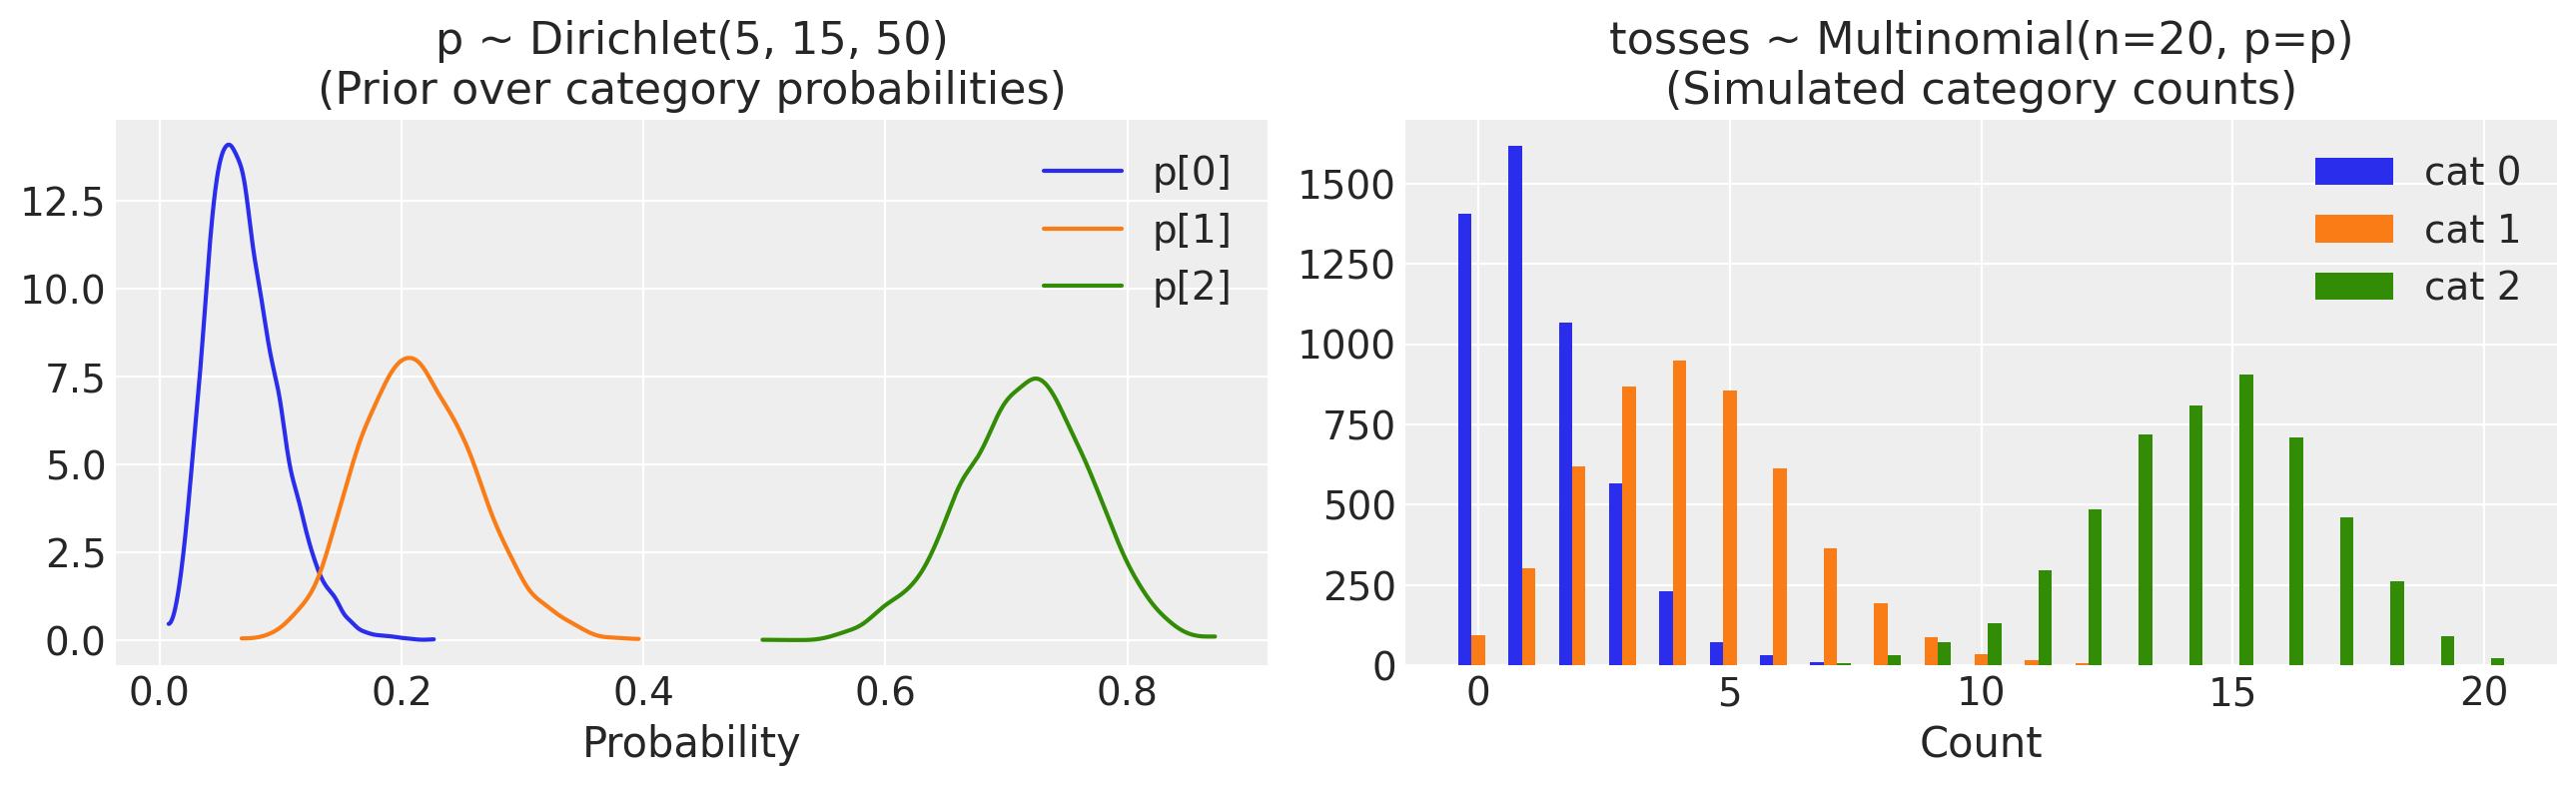

In [ ]:
k = 3
n = 20
a = np.array([5, 15, 50])

with pm.Model():
    p = pm.Dirichlet('p', a=a)

    tosses = pm.Multinomial('tosses', n=n, p=p)

draws = pm.draw([p, tosses], draws=5000)

p_draws = draws[0]
toss_draws = draws[1]

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

for i in range(k):
    az.plot_dist(p_draws[:, i], ax=axes[0], kind='kde', color=f'C{i}', label=f'p[{i}]')
axes[0].set_title(f'p ~ Dirichlet({", ".join([str(ai) for ai in a])})\n(Prior over category probabilities)')
axes[0].set_xlabel('Probability')
axes[0].legend()

axes[1].hist(toss_draws, bins=np.arange(-0.5, n+1, 1), label=[f'cat {i}' for i in range(k)])
axes[1].set_title(f'tosses ~ Multinomial(n={n}, p=p)\n(Simulated category counts)')
axes[1].set_xlabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

# Exercise 1 - Mixture with Dirichlet priors

Re-read the mixture exercise from Lecture 4.

You are given mixture_data.csv as observed data. Create a PyMC program similar to the mixture model presented in the lecture. This time, model the prior probabilities for the mixture with a Dirichlet random variable. Validate your model with predictive posterior check and predict the most probable cluster for x=0.7

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

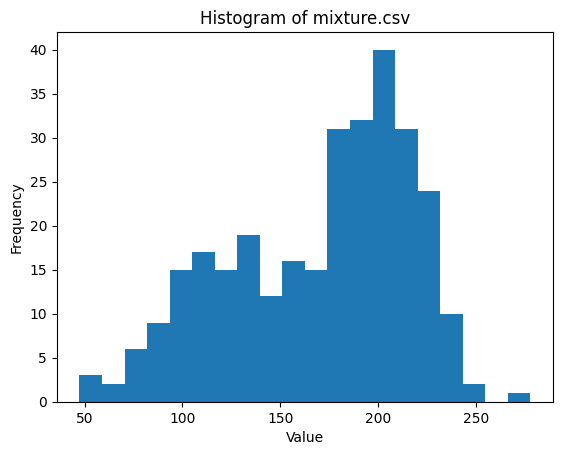

In [ ]:
data = np.loadtxt("mixture_data.csv")
plt.figure()
plt.hist(data, bins=20)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of mixture.csv")
plt.show()

In [ ]:
with pm.Model() as model_ex1:
  p=pm.Dirichlet("p_clusters",a=np.array([1,1]))
  assignment = pm.Categorical("assignment",p, shape=data.shape[0], initval=np.random.randint(0, 2, data.shape[0]))

  centers = pm.Normal("centers",mu=np.array([120, 190]),sigma=np.array([10, 10]),shape=2)

  sds = pm.HalfNormal("sds",sigma=20,shape=2)

  center_i = pm.Deterministic("center_i", centers[assignment])
  sd_i = pm.Deterministic("sd_i", sds[assignment])

  obs = pm.Normal("obs",mu=center_i,sigma=sd_i,observed=data)

  trace=pm.sample(5000, chains=4, return_inferencedata= True)


Output()

/usr/local/lib/python3.12/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [ ]:
with model_ex1:
  ppc = pm.sample_posterior_predictive(trace, var_names=["obs"])

Output()

In [ ]:
y_pred = ppc.posterior_predictive["obs"].values  # shape: (chains, draws, data_points)
y_pred = y_pred.reshape(-1, y_pred.shape[-1])

In [ ]:
centers_mean = trace.posterior["centers"].mean(dim=("chain","draw")).values
sds_mean = trace.posterior["sds"].mean(dim=("chain","draw")).values

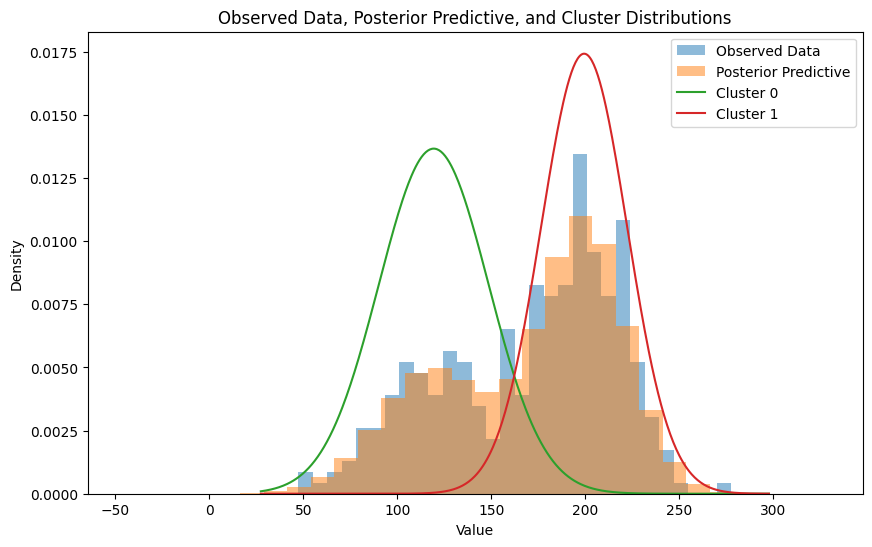

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(data, bins=30, density=True, alpha=0.5, label="Observed Data")

plt.hist(y_pred.flatten(), bins=30, density=True, alpha=0.5, label="Posterior Predictive")

x = np.linspace(data.min()-20, data.max()+20, 500)
for i in range(len(centers_mean)):
    plt.plot(x,1/(sds_mean[i]*np.sqrt(2*np.pi))*np.exp(-(x-centers_mean[i])**2/(2*sds_mean[i]**2)),label=f"Cluster {i}")

plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Observed Data, Posterior Predictive, and Cluster Distributions")
plt.legend()
plt.show()

In [ ]:
from scipy import stats
import numpy as np

x = 0.7

# cluster parameters
mu = centers_mean
sigma = sds_mean
pi = trace.posterior["p_clusters"].mean(dim=("chain","draw")).values

# compute unnormalized probabilities
prob_unnorm = pi * stats.norm.pdf(x, loc=mu, scale=sigma)

# normalize to sum to 1
prob_cluster = prob_unnorm / prob_unnorm.sum()

prob_cluster = np.round(prob_cluster, 3)

print("Probability x belongs to each cluster:", prob_cluster)


Probability x belongs to each cluster: [1. 0.]


# Exercise 2 - Latent Dirichlet Allocation (LDA)

## Latent Dirichlet Allocation (LDA)

Open - https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

LDA is a generative model that aims to find unobserved "topics" in documents. Documents are considered to contain a mixture of topic. For example, if a news article talks about a politician donating funds to a charity, we may see words clustered around politics (*politician*, *funds*, *official*, *electoral*) and some clustered around charity (*needs*, *foundation*, *helping*, *hope*).

The generative story for LDA:

We consider $D$ documents, vocabulary size $V$, and $K$ latent topics.
Document $d$ has a word-count vector $w_d = (w_{d1}, \dots, w_{dV})$ with total count $N_d = \sum_{v=1}^V w_{dv}$.

 - For each topic $k = 1, \dots, K$, draw a distribution over the vocabulary:

$\phi_k \sim \text{Dirichlet}(\beta)$, where $\phi_k = (\phi_{k1}, \dots, \phi_{kV})$

 - For each document $i = 1, \dots, D$, draw a distribution over topics:

$\theta_i \sim \text{Dirichlet}(\alpha)$, where $\theta_i = (\theta_{i1}, \dots, \theta_{iK})$

 - For each ${(i, j)}$ token position in a document, we first sample the topic assigned to that document and generate a word from that topic. This is the basic form of the generative story for a word in a document:


$z_{i,j} \sim \text{Categorical}(\theta_i)$

$w_{i,j} \sim \text{Categorical}(\phi_{z_{i,j}})$

- However, we will use a trick for simplicity:

$(D, K)×(K, V) \implies (D, V)$

Each term in the $(D, V)$ matrix is a *marginalization* over **ALL** topics. We can then use this $(D, V)$ matrix of probabilities as prior for a Multinomial distribution since our observed data is also $(D, V)$, a so-called **document-term** matrix.



In [ ]:
K = 3
docs = [
    "aababaabaaab", "yxxyxyxyyxyxyxyxy", "zbzzzzzzzzzzaz", 'zzzzzzzzzzazzbz',
    'yyxyxyxyxxyxyxy', "abbaabbabab", "zzzzzzzzaz",  "babababaaababaaba",
    "zzzzzzzzzzz", "zzazzzzzzzzzz", "xyxxxyxyxyxyyxyy", "yyxyxyxyxyxxyxy",
    "baabbbabaab", "bbabbabbaabba", "xyxyyyxyxxyxxyxxy"
]

D = len(docs)
vocab = sorted(list(set("".join(docs))))
V = len(vocab)
print("Vocabulary:", vocab)

doc_counts = np.array([
    [doc.count(ch) for ch in vocab]
    for doc in docs
])
print("Document-term matrix:\n", doc_counts)

Vocabulary: ['a', 'b', 'x', 'y', 'z']
Document-term matrix:
 [[ 8  4  0  0  0]
 [ 0  0  8  9  0]
 [ 1  1  0  0 12]
 [ 1  1  0  0 13]
 [ 0  0  7  8  0]
 [ 5  6  0  0  0]
 [ 1  0  0  0  9]
 [10  7  0  0  0]
 [ 0  0  0  0 11]
 [ 1  0  0  0 12]
 [ 0  0  8  8  0]
 [ 0  0  7  8  0]
 [ 5  6  0  0  0]
 [ 5  8  0  0  0]
 [ 0  0  9  8  0]]


In [ ]:
# TODO: write your PyMC model here
with pm.Model() as model:
    phi = pm.Dirichlet("phi", a=np.ones(V), shape=(K, V))

    theta = pm.Dirichlet("theta", a=np.ones(K), shape=(D, K))

    probs = pm.Deterministic("probs", theta @ phi)

    obs = pm.Multinomial(
        "obs",
        n=doc_counts.sum(axis=1),
        p=probs,
        observed=doc_counts
    )

    trace = pm.sample(7000, tune=2000, chains=1, progressbar=True)

# use this for mean ratios of mixtures:

phi_mean = trace.posterior['phi'].mean(('chain', 'draw')).values
theta_mean = trace.posterior['theta'].mean(('chain', 'draw')).values

print('\nTopic-character (K, V) distributions (phi):')
for k in range(K):
    print(f'Topic {k+1}:', {vocab[i]: float(round(phi_mean[k, i], 2)) for i in range(V)})

print('\nDocument-topic (D, K) distributions (theta):')
for d in range(D):
    print(f'Doc {d+1} ({docs[d]}):',
          {f'topic{k+1}': float(round(theta_mean[d, k], 2)) for k in range(K)})

Output()


Topic-character (K, V) distributions (phi):
Topic 1: {'a': 0.5, 'b': 0.46, 'x': 0.02, 'y': 0.01, 'z': 0.02}
Topic 2: {'a': 0.01, 'b': 0.01, 'x': 0.47, 'y': 0.49, 'z': 0.01}
Topic 3: {'a': 0.04, 'b': 0.03, 'x': 0.02, 'y': 0.02, 'z': 0.89}

Document-topic (D, K) distributions (theta):
Doc 1 (aababaabaaab): {'topic1': 0.86, 'topic2': 0.07, 'topic3': 0.07}
Doc 2 (yxxyxyxyyxyxyxyxy): {'topic1': 0.05, 'topic2': 0.89, 'topic3': 0.05}
Doc 3 (zbzzzzzzzzzzaz): {'topic1': 0.14, 'topic2': 0.06, 'topic3': 0.8}
Doc 4 (zzzzzzzzzzazzbz): {'topic1': 0.13, 'topic2': 0.06, 'topic3': 0.81}
Doc 5 (yyxyxyxyxxyxyxy): {'topic1': 0.06, 'topic2': 0.89, 'topic3': 0.06}
Doc 6 (abbaabbabab): {'topic1': 0.85, 'topic2': 0.07, 'topic3': 0.08}
Doc 7 (zzzzzzzzaz): {'topic1': 0.12, 'topic2': 0.08, 'topic3': 0.8}
Doc 8 (babababaaababaaba): {'topic1': 0.89, 'topic2': 0.05, 'topic3': 0.05}
Doc 9 (zzzzzzzzzzz): {'topic1': 0.07, 'topic2': 0.07, 'topic3': 0.86}
Doc 10 (zzazzzzzzzzzz): {'topic1': 0.1, 'topic2': 0.07, 'topic3'